In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path

In [2]:
# 读取Excel文件
df_member = pd.read_excel('../data/Q2.xlsx')
df_task = pd.read_excel('../data/combined_tasks.xlsx')  

In [3]:
df_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况
0,A0001,22.566142,113.980837,66.605203,1
1,A0002,22.686205,113.940525,67.486857,0
2,A0003,22.576512,113.957198,66.081525,0
3,A0004,22.564841,114.244571,65.580365,0
4,A0005,22.558888,113.950723,65.889314,0
...,...,...,...,...,...
830,A0807,23.039098,113.773178,65.500000,1
831,A0808,22.846704,114.159286,85.000000,1
832,A0828,23.012808,113.760312,66.000000,1
833,A0833,22.814676,113.827731,85.000000,1


In [4]:
from sklearn.cluster import DBSCAN
import numpy as np

# 准备地理坐标数据
coords = df_task[['任务gps纬度', '任务gps经度']].values

# 定义1公里内的任务点为一个簇
kms_per_radian = 6371.0088  # 地球半径，单位为公里
epsilon = 1 / kms_per_radian  # 转换为弧度

# 初次聚类
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
df_task['initial_cluster'] = db.labels_

# 初始化 final_cluster 列
df_task['final_cluster'] = -1

# 初始化聚类标签
final_cluster_id = 0

# 处理初次聚类中点数超过4个的类
for cluster_id in np.unique(df_task['initial_cluster']):
    sub_cluster = df_task[df_task['initial_cluster'] == cluster_id]
    
    if len(sub_cluster) > 4:
        sub_coords = sub_cluster[['任务gps纬度', '任务gps经度']].values
        
        # 将超出4个点的聚类再次进行划分
        num_subclusters = int(np.ceil(len(sub_cluster) / 4))
        for i in range(num_subclusters):
            start_idx = i * 4
            end_idx = min(start_idx + 4, len(sub_cluster))
            df_task.loc[sub_cluster.index[start_idx:end_idx], 'final_cluster'] = final_cluster_id
            final_cluster_id += 1
    else:
        df_task.loc[sub_cluster.index, 'final_cluster'] = final_cluster_id
        final_cluster_id += 1

# 检查每个聚类的大小
cluster_sizes = df_task['final_cluster'].value_counts()
print(cluster_sizes)


final_cluster
0      4
34     4
391    4
209    4
208    4
      ..
230    1
229    1
226    1
225    1
492    1
Name: count, Length: 493, dtype: int64


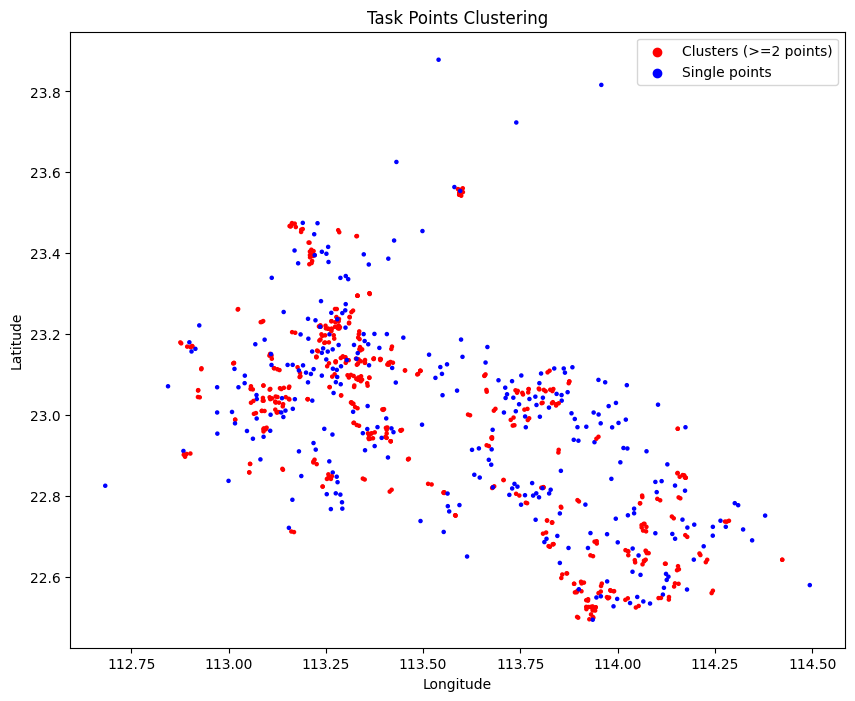

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 df_task 已经有了 'cluster' 列，表示每个任务点的聚类标签
# 你可以将数据加载到 df_task 中
# df_task = pd.read_csv('your_data.csv')

# 统计每个聚类的数量
cluster_counts = df_task['final_cluster'].value_counts()

# 将每个任务点的颜色分配为红色或蓝色
colors = df_task['final_cluster'].apply(lambda x: 'red' if cluster_counts[x] > 1 else 'blue')

# 画散点图
plt.figure(figsize=(10, 8))
plt.scatter(df_task['任务gps经度'], df_task['任务gps纬度'], c=colors, s=5)  # 调整点的大小为50

# 添加图例
plt.scatter([], [], c='red', label='Clusters (>=2 points)')
plt.scatter([], [], c='blue', label='Single points')

plt.title('Task Points Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='best')
# plt.show()
# 保存更高分辨率的图片
plt.savefig('cluster.png', dpi=300, bbox_inches='tight')

## 预测完成率

In [6]:
# 可以基于每个聚类中任务点的历史完成率来预测整体完成率
# 简单示例：聚类中的所有任务点都完成则聚类任务完成，否则聚类任务未完成

def predict_completion_rate(cluster_id):
    tasks_in_cluster = df_task[df_task['final_cluster'] == cluster_id]
    completed_tasks = tasks_in_cluster['任务执行情况'].sum()
    total_tasks = len(tasks_in_cluster)
    completion_rate = completed_tasks / total_tasks
    return completion_rate

# 计算每个聚类的任务完成率
df_task['预测完成率'] = df_task['final_cluster'].apply(predict_completion_rate)

# 查看预测完成率
df_task


,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,initial_cluster,final_cluster,预测完成率
0,A0001,22.566142,113.980837,66.605203,1,0,0,0.25
1,A0002,22.686205,113.940525,67.486857,0,1,1,0.00
2,A0003,22.576512,113.957198,66.081525,0,2,2,0.00
3,A0004,22.564841,114.244571,65.580365,0,3,3,0.00
4,A0005,22.558888,113.950723,65.889314,0,4,4,0.00
...,...,...,...,...,...,...,...,...
830,A0807,23.039098,113.773178,65.500000,1,460,491,1.00
831,A0808,22.846704,114.159286,85.000000,1,356,385,1.00
832,A0828,23.012808,113.760312,66.000000,1,378,408,1.00
833,A0833,22.814676,113.827731,85.000000,1,461,492,1.00


In [7]:
df_task['预测完成率'].sum()

577.0

### 二分类计算完成率

In [8]:
# 确保列名正确无误
if '预测完成率' in df_task.columns:
    # 将任务完成率进行二分类，> 0.5 视为已完成，<= 0.5 视为未完成
    df_task['任务是否完成'] = df_task['预测完成率'].apply(lambda x: 1 if x >= 0.5
                                               else 0)

    # 统计已完成任务的数量
    completed_tasks_count = df_task['任务是否完成'].sum()

    # 查看统计结果
    print(f"已完成的任务数量: {completed_tasks_count}")

    # 查看处理后的 DataFrame
    df_task

已完成的任务数量: 603


## 调整新价格

In [9]:
def optimize_price(base_price, cluster_size, distance_from_center):
    """
    基础价格：base_price
    聚类规模：cluster_size
    距离聚类中心的距离：distance_from_center
    """
    cluster_adjustment = 1 + 0.05 * (cluster_size - 1)  # 聚类规模调整因子
    distance_adjustment = 1 - 0.05 * distance_from_center  # 距离因素调整因子
    return base_price * cluster_adjustment * distance_adjustment

# 计算每个聚类的中心点
cluster_centers = df_task.groupby('final_cluster')[['任务gps纬度', '任务gps经度']].mean()

# 初始化调整后的价格列
df_task['优化后的任务标价'] = df_task['任务标价']  # 以原始标价作为基础

# 对每个任务点执行优化定价
for cluster_id, center in cluster_centers.iterrows():
    cluster_tasks = df_task[df_task['final_cluster'] == cluster_id]
    cluster_size = len(cluster_tasks)
    
    for idx, task in cluster_tasks.iterrows():
        # 计算任务点到聚类中心的距离
        distance_from_center = np.sqrt((task['任务gps纬度'] - center['任务gps纬度']) ** 2 + 
                                       (task['任务gps经度'] - center['任务gps经度']) ** 2)
        
        # 优化价格
        optimized_price = optimize_price(task['任务标价'], cluster_size, distance_from_center)
        df_task.at[idx, '优化后的任务标价'] = optimized_price

# 查看优化后的数据
print(df_task[['任务gps纬度', '任务gps经度', '任务标价', '优化后的任务标价', 'final_cluster']])


       任务gps纬度     任务gps经度       任务标价   优化后的任务标价  final_cluster
0    22.566142  113.980837  66.605203  76.576235              0
1    22.686205  113.940525  67.486857  74.221110              1
2    22.576512  113.957198  66.081525  69.374788              2
3    22.564841  114.244571  65.580365  68.847872              3
4    22.558888  113.950723  65.889314  69.171632              4
..         ...         ...        ...        ...            ...
830  23.039098  113.773178  65.500000  65.500000            491
831  22.846704  114.159286  85.000000  89.214610            385
832  23.012808  113.760312  66.000000  69.286189            408
833  22.814676  113.827731  85.000000  85.000000            492
834  23.063674  113.771188  65.500000  72.039786            400

[835 rows x 5 columns]


In [10]:
df_task['优化后的任务标价'].mean()

71.97773009910345

In [11]:
df_task['优化后的任务标价'].sum()

60101.40463275138

In [12]:
df_task

,任务号码,任务gps纬度,任务gps经度,任务标价,任务执行情况,initial_cluster,final_cluster,预测完成率,任务是否完成,优化后的任务标价
0,A0001,22.566142,113.980837,66.605203,1,0,0,0.25,0,76.576235
1,A0002,22.686205,113.940525,67.486857,0,1,1,0.00,0,74.221110
2,A0003,22.576512,113.957198,66.081525,0,2,2,0.00,0,69.374788
3,A0004,22.564841,114.244571,65.580365,0,3,3,0.00,0,68.847872
4,A0005,22.558888,113.950723,65.889314,0,4,4,0.00,0,69.171632
...,...,...,...,...,...,...,...,...,...,...
830,A0807,23.039098,113.773178,65.500000,1,460,491,1.00,1,65.500000
831,A0808,22.846704,114.159286,85.000000,1,356,385,1.00,1,89.214610
832,A0828,23.012808,113.760312,66.000000,1,378,408,1.00,1,69.286189
833,A0833,22.814676,113.827731,85.000000,1,461,492,1.00,1,85.000000


In [13]:
df_task[['任务号码', '任务gps纬度', '任务gps经度', '任务标价', '优化后的任务标价', 'final_cluster']]

,任务号码,任务gps纬度,任务gps经度,任务标价,优化后的任务标价,final_cluster
0,A0001,22.566142,113.980837,66.605203,76.576235,0
1,A0002,22.686205,113.940525,67.486857,74.221110,1
2,A0003,22.576512,113.957198,66.081525,69.374788,2
3,A0004,22.564841,114.244571,65.580365,68.847872,3
4,A0005,22.558888,113.950723,65.889314,69.171632,4
...,...,...,...,...,...,...
830,A0807,23.039098,113.773178,65.500000,65.500000,491
831,A0808,22.846704,114.159286,85.000000,89.214610,385
832,A0828,23.012808,113.760312,66.000000,69.286189,408
833,A0833,22.814676,113.827731,85.000000,85.000000,492
